# Importing and creating important functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import pandas as pd
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

%matplotlib inline

In [172]:
@jit(nopython=True)
def generate_v_OU(nr_trials=1000, noise_sd=1, tmax=5, dt=0.01, start=2, end=5):
    
    start = int(start/dt)
    end = int(end/dt)
    
    v = np.zeros(shape=(2, nr_trials, 500))
    v[0, :, start:end] = 1*dt
    
    
    for i in range(500):
        v[0, :, i] += np.random.normal(0, noise_sd/np.sqrt(2), nr_trials)*np.sqrt(dt)
        v[1, :, i] += np.random.normal(0, noise_sd/np.sqrt(2), nr_trials)*np.sqrt(dt)
    
    return v
    
    
    
@jit(nopython=True)   

def get_OU_traces(v, ll, dc, z, noise_sd=1, pre_generated=False, nr_trials=1000, tmax=5.0, dt=0.01):
    
    
    x1 = np.zeros((nr_trials, int(tmax/dt)))
    x2 = np.zeros((nr_trials, int(tmax/dt)))
    x1[:,:] = np.NaN
    x2[:,:] = np.NaN
    x1[:,0] = z[0]
    x2[:,0] = z[1]
    for i in range((int(tmax/dt))-1):
        if pre_generated:
            x1[:,i+1] = x1[:,i] + v[0][:,i] + (dc[0] - (ll[0]*x1[:,i]))*dt
            x2[:,i+1] = x2[:,i] + v[1][:,i] + (dc[1] - (ll[1]*x2[:,i]))*dt
        else:
            x1[:,i+1] = x1[:,i] + ((v[0] + dc[0] - (ll[0]*x1[:,i])) * dt) +(np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
            x2[:,i+1] = x2[:,i] + ((v[1] + dc[1] - (ll[1]*x2[:,i])) * dt) + (np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
    return x1-x2

@jit(nopython=True)
def apply_bounds_diff_trace(x, b1, b0):
    rt = np.zeros(x.shape[0])
    rt[:] = np.nan
    response = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i,j] >= b1[j]:
                rt[i] = j
                response[i] = 1
                break
    return rt, response



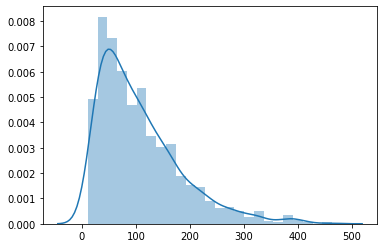

In [257]:
v = generate_v_OU(start=2, end =5)
ll = [0, 0]
dc = [0, 0]
z = [0, 0]
x = get_OU_traces(v, ll, dc, z, pre_generated=True)
b1 = np.ones(x.shape[0])
b0 = np.ones(x.shape[0]) * -1
rt, response = apply_bounds_diff_trace(x, b1, b0)
df = pd.DataFrame()
df['rt'] = rt
df['response'] = response
sns.distplot(rt)

# Creating a function and interactive vizualization for the OU model

In [4]:
def do_sim():
    
    dt = 0.01
    
    start = 2
    end = 5
    

    v = generate_v_OU(start=start, end =end)
    ll = [0, 0]
    dc = [0.01, 0]
    z = [0, 0]
    x = get_OU_traces(v, ll, dc, z, pre_generated=True)
    b1 = np.ones(x.shape[0])
    b0 = np.ones(x.shape[0]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] > start) & (df['rt'] < end)
    df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    gb = df.groupby('rt quantile').mean()
    plt.plot(gb['false alarm'], 'go-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'false alarm', markeredgewidth = 2)
    
    plt.plot(gb['hit'], 'ro-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'hit', markeredgewidth = 2)
    
    
    plt.legend()
    
    
    print(gb)

    plt.figure()
    
    
    sns.distplot(rt)

In [286]:
w = interactive(do_sim)
display(w)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

# optimizing the hr and fa rate

In [142]:
def do_sim(ll):
    
    dt = 0.01
    
    start = 2
    end = 5
    

    v = generate_v_OU(start=start, end=end)
    ll = [ll, 0.0]
    dc = [0, 0]
    z = [0, 0]

    
    x = get_OU_traces(v=v, ll=ll, dc=dc, z=z, pre_generated=True, nr_trials=1000, tmax = 5.0, dt=0.01)
    b1 = np.ones(x.shape[0])
    b0 = np.ones(x.shape[0]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] > start) & (df['rt'] < end)
    df['miss'] = (~df['hit']) & (~df['false alarm'])
    #df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    fa_rate = df['false alarm'].mean()
    hit_rate = df['hit'].mean() / (df['hit'].mean() + df['miss'].mean())
    
    return (fa_rate, hit_rate)
    


In [173]:
def do_mod_sim(ll):
    
    dt = 0.01
    
    start = 2.0
    end = 5.0
    

#     v = generate_v_OU(start=start, end=end)
    ll = [ll, ll]
    dc = [0.0, 0.0]
    z = [0.0, 0.0]

    
    x = get_OU_traces(v=v, ll=ll, dc=dc, z=z, pre_generated=True, nr_trials=200, tmax = 5.0, dt=0.01)
    b1 = np.ones(x.shape[0])
    b0 = np.ones(x.shape[0]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] >= start)
    df['miss'] = (~df['hit']) & (~df['false alarm'])
    #df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    return (x, df, df['false alarm'].mean(), df['hit'].mean(), df['miss'].mean(), df['rt'].mean())

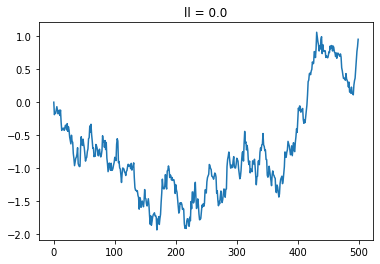

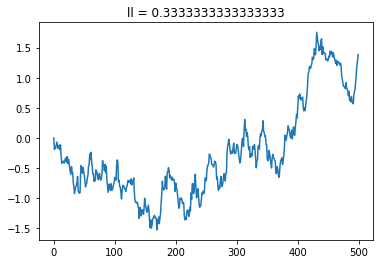

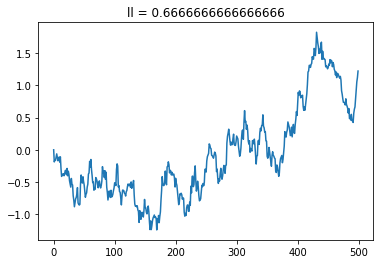

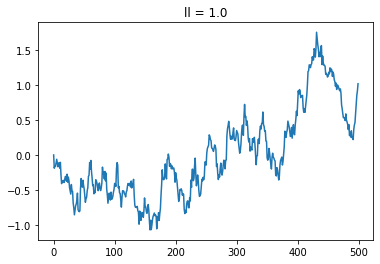

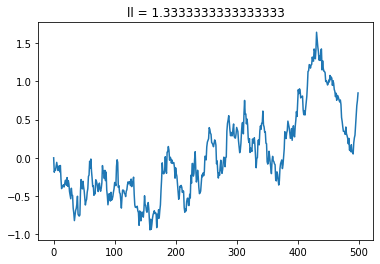

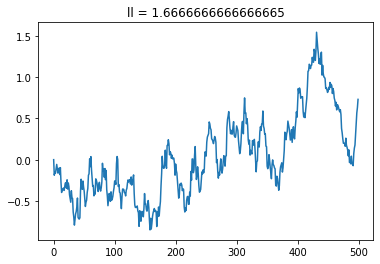

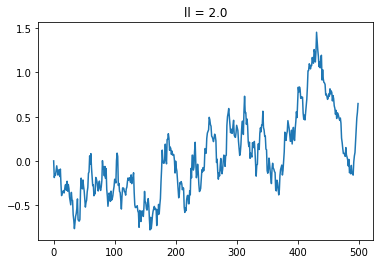

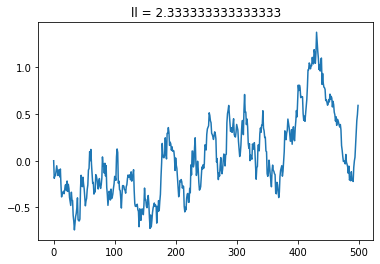

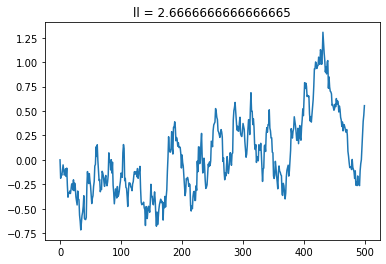

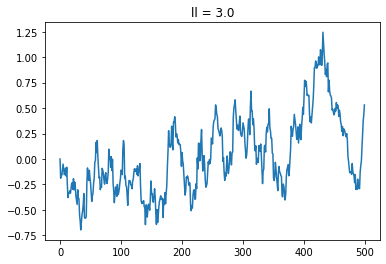

In [174]:
%matplotlib inline
a = np.linspace(0, 3, 10)

for i in a:
    plt.figure()
    x, df, f, h, m, r = do_mod_sim(i)
    plt.plot(x[0])
    plt.title(f'll = {i}')


In [151]:
import time

start = time.time()

n = 10
far = np.zeros(n*2)
hit = np.zeros(n*2)
miss = np.zeros(n*2)
rt = np.zeros(n*2)
ll = np.zeros(n*2)
v = generate_v_OU(nr_trials = 200, start=2, end=5)
params = np.linspace(0, 1, 10)



for i in range(len(params)):
    df, f, h, m, r = do_mod_sim(params[i])
    far[i] = f
    hit[i] = h 
    miss[i] = m
    rt[i] = r
    ll[i] = params[i]
    

    
# print(fl)
# print(hl)
print(time.time() - start)

0.30736207962036133


In [155]:
hit

array([0.54, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.93, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

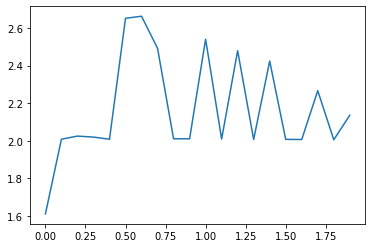

In [152]:
%matplotlib inline

plt.plot(ll, rt)

ValueError: x and y must have same first dimension, but have shapes (20,) and (200,)

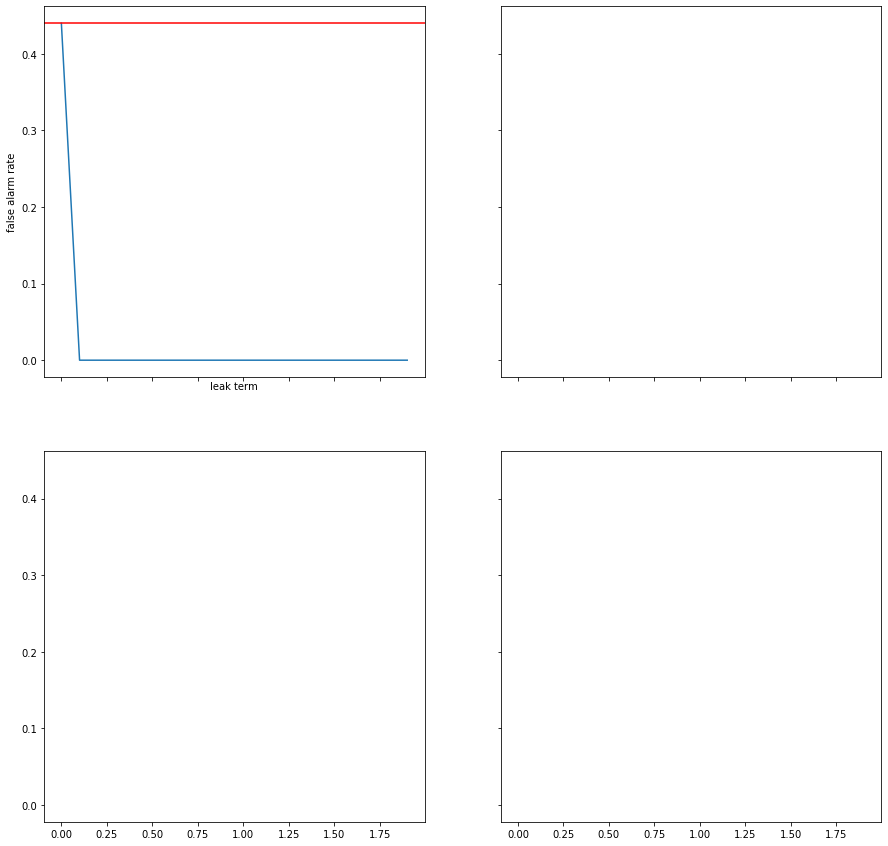

In [153]:
%matplotlib qt
fig, axes = plt.subplots(2, 2, figsize = (15, 15), sharex = True, sharey = True)
axes[0, 0].plot(ll, far)
axes[0, 0].set_xlabel('leak term')
axes[0, 0].set_ylabel('false alarm rate')
axes[0, 0].axhline(np.max(far), color = 'red')



axes[0, 1].plot(ll, hr)
axes[0, 1].set_xlabel('leak term')
axes[0, 1].set_ylabel('hit rate')
axes[0, 1].axhline(np.max(hr), color = 'red')

axes[1, 0].plot(ll, acc)
axes[1, 0].set_xlabel('leak term')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].axhline(np.max(acc), color = 'red')

axes[1, 1].plot(ll, hr - far)
axes[1, 1].set_xlabel('leak term')
axes[1, 1].set_ylabel('hit rate - false alarms')
axes[1, 1].axhline(np.max(hr-far), color = 'red')

plt.ylim(-1, 1)




# misc stuff

In [332]:
dt = 0.01
start = 2
end = 5


%timeit v = generate_v_OU(start=start, end =end)
ll = [0.0, 0.0]
dc = [0.01, 0.0]
z = [0.0, 0.0]
%timeit x = get_OU_traces(v, ll, dc, z, pre_generated=True, stim=1, nr_trials=1000, tmax = 5.0, dt=0.01)
# b1 = np.ones(x.shape[0])
# b0 = np.ones(x.shape[0]) * -1
x = get_OU_traces(v, ll, dc, z, pre_generated=True, stim=1, nr_trials=1000, tmax = 5.0, dt=0.01)
%timeit rt, response = apply_bounds_diff_trace(x, b1, b0)
df = pd.DataFrame()



df['rt'] = rt * dt
df['response'] = response

df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
df['hit'] = (df['response'] == 1) & (df['rt'] > start) & (df['rt'] < end)
df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)

# gb = df.groupby('rt quantile').mean()
# plt.plot(gb['false alarm'], 'go-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'hit', markeredgewidth = 2)

# plt.plot(gb['false alarm'], 'go-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'hit', markeredgewidth = 2)





80.5 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.4 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
190 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [282]:
v = generate_v_OU(2, 5)

,rt,response,false alarm,hit
rt quantile,,,,
0,0.150250,0.685,0.685,0.00
1,0.403110,1.000,1.000,0.00
2,0.630918,1.000,1.000,0.00
3,0.959744,1.000,1.000,0.00
4,1.884900,1.000,0.685,0.31


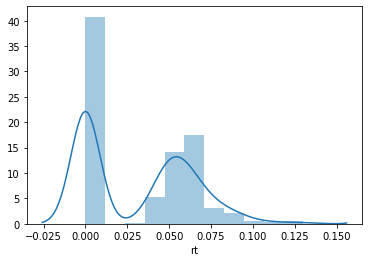

In [272]:
sns.distplot(df['rt'])

In [218]:
quantiles = [int(x/5 * 100)  for x in range(1, 6)]
df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
gb = df.groupby('rt quantile').mean()
gb



,rt,response
rt quantile,,
0,26.338235,0.426471
1,52.844221,0.487437
2,83.333333,0.492537
3,130.301020,0.484694
4,238.250000,0.335000


In [248]:
df['response']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      1.0
6      0.0
7      0.0
8      1.0
9      0.0
10     0.0
11     1.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     1.0
19     0.0
20     0.0
21     1.0
22     0.0
23     1.0
24     1.0
25     1.0
26     0.0
27     0.0
28     0.0
29     1.0
      ... 
970    1.0
971    1.0
972    0.0
973    1.0
974    1.0
975    1.0
976    1.0
977    0.0
978    0.0
979    0.0
980    1.0
981    1.0
982    1.0
983    0.0
984    1.0
985    1.0
986    0.0
987    1.0
988    1.0
989    0.0
990    1.0
991    0.0
992    1.0
993    0.0
994    1.0
995    1.0
996    1.0
997    1.0
998    1.0
999    1.0
Name: response, Length: 1000, dtype: float64

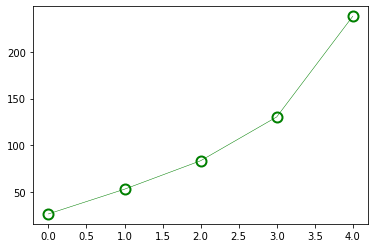

In [207]:
plt.plot(gb['rt'], 'go-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'bias', markeredgewidth = 2)

In [192]:
gb.index

CategoricalIndex([20, 40, 60, 80, 100], categories=[20, 40, 60, 80, 100], ordered=True, name='rt quantile', dtype='category')

In [188]:
gb['rt']

rt quantile
20      26.338235
40      52.844221
60      83.333333
80     130.301020
100    238.250000
Name: rt, dtype: float64

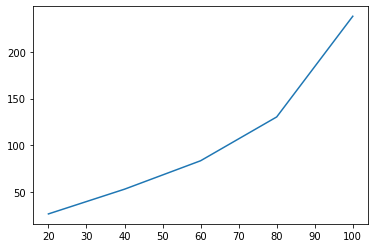

In [196]:
plt.plot(np.asarray(gb.index.values),np.asarray(gb['rt']))

In [195]:
np.asarray(gb.index.values)

array([ 20,  40,  60,  80, 100], dtype=int64)